# Frequency-time Normalisation

This is the script for running frequency-time normalisation with imported modules and Python packages. The logic and mathematics of this normalisation method is based on: 
Shen, Y., Ren, Y., Gao, H. and Savage, B. (2012). An Improved Method to Extract Very‐Broadband Empirical Green’s Functions from Ambient Seismic Noise. Bulletin of the Seismological Society of America, [online] 102(4), pp.1872–1877. doi:10.1785/0120120023. 

## Import modules 

In [1]:
from dependencies import *
import download_raw_data
import processing
import normalisation

## Download raw waveform 

### **Parameter section requires user's inputs**

- You need to specify the rootpath that you want to store the data, and the name of the directory under that rootpath. The directory should be made before executing the following code. 

- dlist is txt file that you will create for station information before executing the following code under the same rootpath. Example is given in the comments. 

- client, samp_freq, rm_resp, freqmin, freqmax, start_date, end_date and inc_hours are parameters that can be changed according to user's request. 

**To download raw waveform, we need to get a list of event first by calling `download_raw_data.get_event_list()`, then obtain the waveform, inventory and datetime info from calling `download_raw_data.download()`**

In [2]:
#########################################################
################ PARAMETER SECTION ######################
#########################################################

# paths and filenames (user defined)
rootpath = '/Users/xulul/Downloads/honours/NoisePy-master/NoisePy-master/FTN'  # roothpath for the project
direc  = os.path.join(rootpath,'DATA_NZ')                                      # where to store the downloaded data
dlist  = os.path.join(rootpath,'test_station_qrz.txt')                         # txt file for station location info

#***************************************************
# below is a snippet of example station list
#network,station,channel,latitude,longitude,elevation
#AU,LHI,BHZ,-31.52,159.061295,73.7
#***************************************************

# download parameters (user defined)
client    = Client('IRIS')                  # client/data center. see https://docs.obspy.org/packages/obspy.clients.fdsn.html for a list
flag      = False                           # print progress when running the script; recommend to use it at the begining
samp_freq = 1                               # targeted sampling rate at X samples per seconds 
rm_resp   = 'inv'                    # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
respdir   = os.path.join(rootpath,'resp')    # directory where instrument response files are located (required if rm_resp is neither 'no' nor 'inv')
freqmin   = 0.005                            # pre filtering minimum frequency bandwidth
freqmax   = 0.1                              # pre filtering maximum frequency bandwidth
                                             #note this cannot exceed Nquist freq (<= 0.5 samp_freq)                        


start_date = ["2021_11_01_11_0_0"]           # start date of download, ["year_month_date_hour_minute_second"]
end_date   = ["2021_11_01_12_0_0"]           # end date of download, ["year_month_date_hour_minute_second"]
inc_hours  = 1                               # length of data for each request (in hour)
    

##################################################
# we expect no parameters need to be changed below

# time tags
starttime = obspy.UTCDateTime(start_date[0])       
endtime   = obspy.UTCDateTime(end_date[0])


# read station info from list
locs = pd.read_csv(dlist)                   
nsta = len(locs)
chan = list(locs.iloc[:]['channel'])
net  = list(locs.iloc[:]['network'])
sta  = list(locs.iloc[:]['station'])
lat  = list(locs.iloc[:]['latitude'])
lon  = list(locs.iloc[:]['longitude'])

# assemble parameters used for pre-processing
prepro_para = {'rm_resp':rm_resp,
               'respdir':respdir,
               'freqmin':freqmin,
               'freqmax':freqmax,
               'samp_freq':samp_freq,
               'start_date':start_date,
               'end_date':end_date,
               'inc_hours':inc_hours}

# location info: useful for some occasion
try:
    location = list(locs.iloc[:]['location'])
except Exception as e:
    location = ['*']*nsta



In [3]:
#check if the rootpath and directory exist
if not os.path.isdir(rootpath):
    os.mkdir(rootpath)
if not os.path.isdir(direc):
        os.mkdir(direc)

In [3]:
# get all event list ready
all_chunk = download_raw_data.get_event_list(start_date[0],end_date[0],inc_hours)


In [4]:
# retreive waveform as Obspy trace and corresponding inventories
tr_list, inv_list, date_info = download_raw_data.download(all_chunk,nsta,net,sta,location,direc,chan,client,1)


## Plot raw waveform 



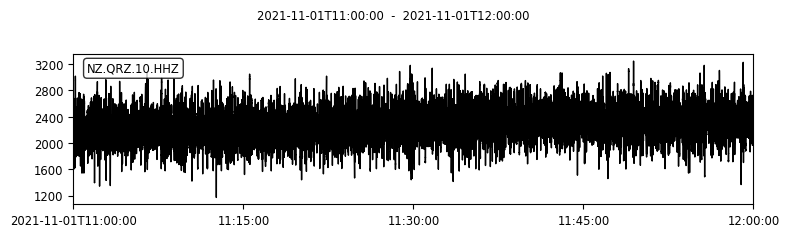

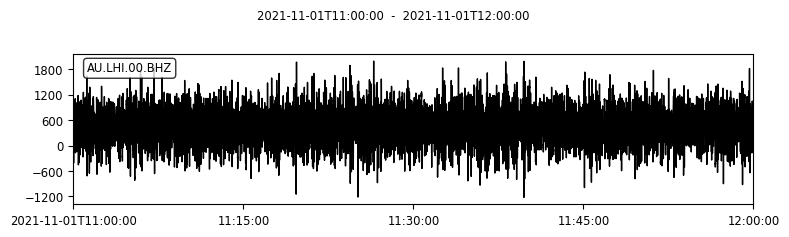

In [5]:
# loop through and plot all the traces in tr_list
for i in range(len(tr_list)): 
    tr_list[i].plot()

In [6]:
tr_list

[1 Trace(s) in Stream:
NZ.QRZ.10.HHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 100.0 Hz, 360001 samples,
 1 Trace(s) in Stream:
AU.LHI.00.BHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 40.0 Hz, 144001 samples]

## Pre-processing raw waveform 

This step pre-process the raw waveform:

- `processing.check_sample_gaps` checks gaps of data in the raw waveform 

- `processing.preprocess_raw` performs majority of pre-processing including demean, detrend, taper, filtering, and removing instrument resonse. 

In [7]:
# check gaps in obspy traces

st_list = []
for i in range(len(tr_list)):
    st = processing.check_sample_gaps(tr_list[i],date_info)
    st_list.append(st)

st_list

[1 Trace(s) in Stream:
NZ.QRZ.10.HHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 100.0 Hz, 360001 samples,
 1 Trace(s) in Stream:
AU.LHI.00.BHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 40.0 Hz, 144001 samples]

In [8]:
# demean, detrend, taper, filter, and remove instrument response

ntr_list = []
for i in range(len(st_list)):
    ntr = processing.preprocess_raw(st_list[i],inv_list[i],prepro_para,date_info)
    ntr_list.append(ntr)
        
        
        

removing response for NZ.QRZ.10.HHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 100.0 Hz, 360001 samples using inv
removing response for AU.LHI.00.BHZ | 2021-11-01T11:00:00.000000Z - 2021-11-01T12:00:00.000000Z | 40.0 Hz, 144001 samples using inv


## Plot pre-processed waveform

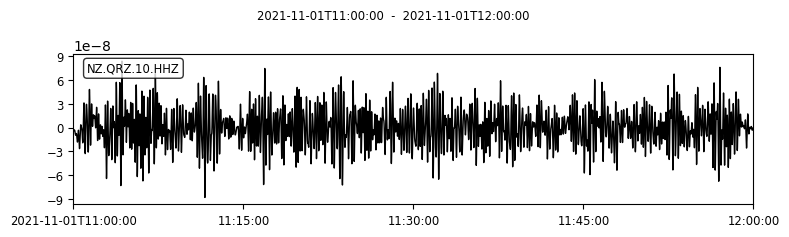

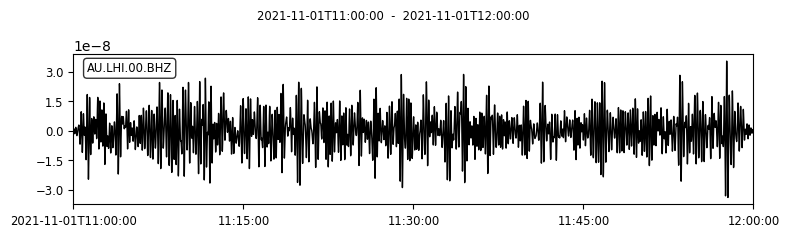

In [9]:
# loop through and plot all the traces in ntr_list
for i in range(len(ntr_list)): 
    ntr_list[i].plot()

## Filtering for normalisation 

Now we need to do filtering for normalisation. 

First we need to find the targeted fequency range for each station according to their instrument type using `normalisation.target_frequency()`. 

Next within this frequency range, we need to slice it into different windows with the same interval using `normalisation.target_frequency_window()`. 


In [10]:
# target filtering frequency range for each channel 

target_freq_range = []

for channel in chan:
    freq_range = normalisation.target_frequency(channel, freqmin, freqmax)
    target_freq_range.append(freq_range)

target_freq_range

[(0.005, 0.07), (0.005, 0.07)]

In [11]:
# filtering frequency windows 

target_freq_window = []

for channel in chan: 
    freq_window = normalisation.target_frequency_window(channel, freqmin, freqmax)
    target_freq_window.append(freq_window)


## Frequency-time normalisation

With the frequency windows, now we can perform normalisation using `normalisation.freq_time_normalisation()`. 

After normalisation, we need to sum all the frequency windows up to return a finalised waveform. 

Lastly, we visualise the normalised waveform. 

In [12]:
# frquency-time normalisation 

FTN_trace_list = []
for i in range(len(target_freq_window)): 
    FTN_trace = normalisation.freq_time_normalisation(target_freq_window[i], samp_freq, ntr_list[i])
    FTN_trace_list.append(FTN_trace)


In [13]:
#sum of all the frequency windows 

sum_FTN_list = []
for i in range(len(FTN_trace_list)):
    sum_FTN = sum(FTN_trace_list[i])
    sum_FTN_list.append(sum_FTN)


<Figure size 1440x720 with 0 Axes>

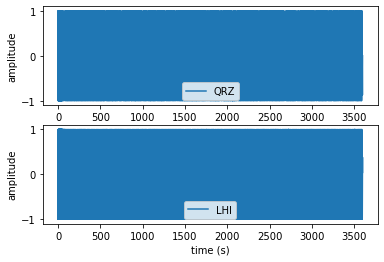

In [14]:
# Visualisation

from matplotlib import pyplot as plt

plt.figure(figsize = (20,10))
fig, axs = plt.subplots(len(sum_FTN_list))



for i in range (len(sum_FTN_list)):
    #calculate time in seconds
    t = np.arange(0, st_list[i][0].stats.npts / st_list[i][0].stats.sampling_rate, st_list[i][0].stats.delta) 
    axs[i].plot(t, sum_FTN_list[i], label = st_list[i][0].stats.station)
    axs[i].set_xlabel('time (s)')
    axs[i].set_ylabel('amplitude')
    axs[i].legend(loc ='lower center')

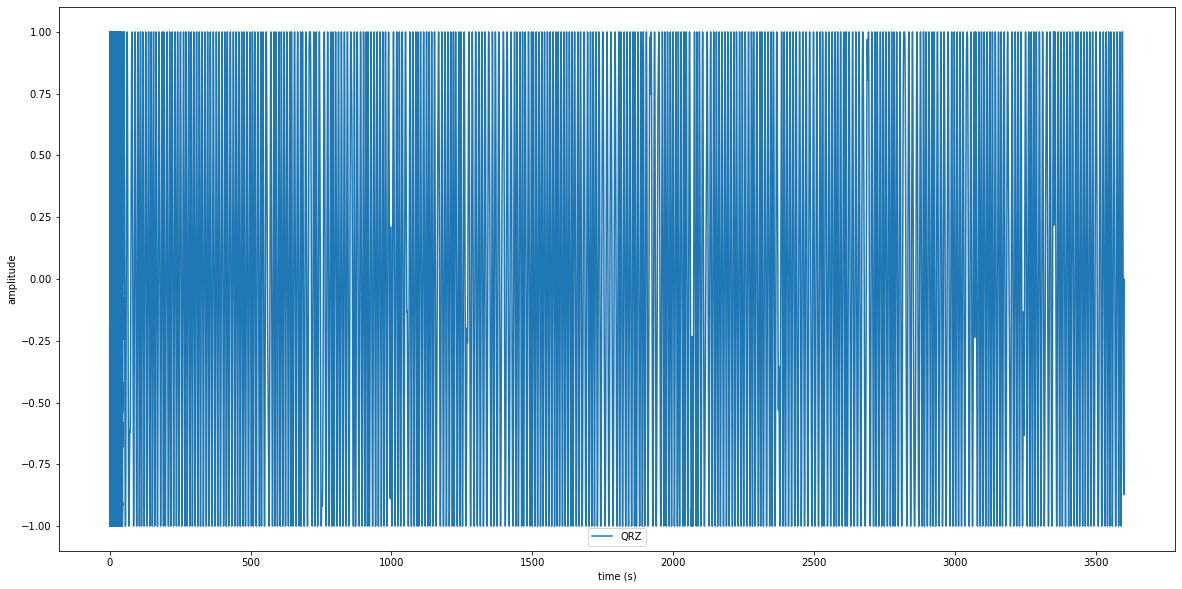

In [15]:
plt.figure(figsize = (20,10))
t = np.arange(0, st_list[0][0].stats.npts / st_list[0][0].stats.sampling_rate, st_list[0][0].stats.delta)
plt.plot(t, sum_FTN_list[0], label = st_list[0][0].stats.station)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.legend(loc ='lower center')